<a href="https://colab.research.google.com/github/JunandaSap/TA/blob/main/Amplitudo_R_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb librosa matplotlib

import os
import zipfile
import wfdb
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from google.colab import drive
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Hubungkan Google Colab dengan Google Drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/TA/ptb-diagnostic-ecg-database-1.0.0.zip'

extract_dir = '/content/extracted_zip'
os.makedirs(extract_dir, exist_ok=True)

# Ekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("File yang diekstrak:")
print(os.listdir(extract_dir))

Mounted at /content/drive
File yang diekstrak:
['ptb-diagnostic-ecg-database-1.0.0']


In [ ]:
# Melihat isi dari folder yang diekstrak
dataset_folder = os.path.join(extract_dir, 'ptb-diagnostic-ecg-database-1.0.0')
inner_files = os.listdir(dataset_folder)
print(inner_files)

['patient069', 'patient216', 'patient168', 'patient262', 'patient079', 'patient154', 'patient130', 'patient040', 'patient208', 'patient148', 'patient252', 'patient030', 'patient188', 'patient179', 'patient026', 'patient173', 'patient062', 'patient214', 'patient011', 'patient018', 'patient178', 'patient074', 'patient072', 'patient276', 'patient086', 'patient004', 'patient287', 'patient273', 'patient044', 'patient136', 'patient083', 'patient099', 'patient174', 'patient014', 'patient080', 'patient071', 'patient247', 'patient246', 'patient107', 'patient113', 'patient182', 'patient222', 'patient095', 'patient125', 'patient215', 'patient021', 'patient029', 'patient176', 'patient006', 'patient192', 'patient144', 'patient097', 'patient126', 'patient081', 'patient047', 'patient128', 'patient255', 'patient146', 'patient228', 'patient175', 'patient052', 'patient034', 'patient016', 'patient221', 'patient293', 'patient177', 'patient162', 'patient206', 'patient166', 'patient068', 'patient022', 'pati

Bentuk sinyal: (38400, 15)
Frekuensi sampel: 1000


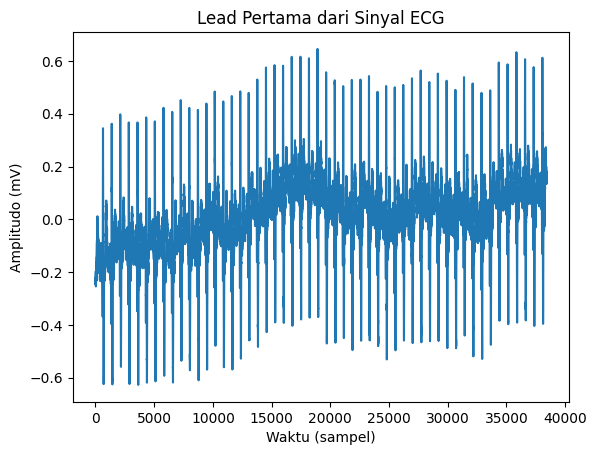

In [ ]:
import wfdb

# Ambil salah satu file (contoh)
record_name = os.path.join(dataset_folder, 'patient001/s0010_re')  # Sesuaikan path

# Membaca sinyal dan metadata
record = wfdb.rdrecord(record_name)
signal = record.p_signal  # Sinyal ECG untuk semua lead
sampling_rate = record.fs  # Frekuensi sampel
print("Bentuk sinyal:", signal.shape)
print("Frekuensi sampel:", sampling_rate)

# Visualisasi sinyal
import matplotlib.pyplot as plt
plt.plot(signal[:, 0])  # Plot lead pertama
plt.title('Lead Pertama dari Sinyal ECG')
plt.xlabel('Waktu (sampel)')
plt.ylabel('Amplitudo (mV)')
plt.show()


In [ ]:
!pip install biosppy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from wfdb import rdrecord
from scipy.signal import find_peaks, butter, filtfilt

# Path dataset
dataset_path = 'extracted_zip/ptb-diagnostic-ecg-database-1.0.0'

# Fungsi untuk Bandpass Filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Fungsi untuk mengekstrak fitur amplitudo RS
def extract_rs_features(file_path):
    record = rdrecord(file_path)
    signal = record.p_signal  # Sinyal ECG
    fs = record.fs           # Frekuensi sampling
    leads = record.sig_name  # Nama leads
    patient_features = []

    # Iterasi untuk setiap lead
    for i, lead_signal in enumerate(signal.T):
        # Filter sinyal
        filtered_signal = bandpass_filter(lead_signal, lowcut=0.5, highcut=50, fs=fs)

        # Deteksi puncak R
        peaks_R, _ = find_peaks(filtered_signal, height=0.5, distance=int(fs * 0.6))

        # Deteksi posisi S setelah R
        indices_S = []
        for r in peaks_R:
            window = filtered_signal[r:r + int(fs * 0.1)]  # 100 ms setelah R
            if len(window) > 0:
                s_idx = np.argmin(window)
                indices_S.append(r + s_idx)

        # Hitung amplitudo RS
        if len(peaks_R) > 0 and len(indices_S) > 0:
            amplitudes_RS = filtered_signal[peaks_R[:len(indices_S)]] - filtered_signal[indices_S]

            # Fitur agregat
            mean_rs = np.mean(amplitudes_RS)
            max_rs = np.max(amplitudes_RS)
            min_rs = np.min(amplitudes_RS)
            std_rs = np.std(amplitudes_RS)

            # Simpan semua fitur
            patient_features.append({
                'Lead': leads[i],
                'Mean_RS': mean_rs,
                'Max_RS': max_rs,
                'Min_RS': min_rs,
                'Std_RS': std_rs,
                'RS_Amplitudes': amplitudes_RS.tolist()  # Simpan nilai individu
            })

    return patient_features

# Iterasi melalui semua file dalam folder dataset
all_patient_features = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.hea'):  # File header untuk sinyal ECG
            file_path = os.path.join(root, file[:-4])  # Hapus ekstensi untuk membaca file
            try:
                # Ekstraksi fitur untuk file
                features = extract_rs_features(file_path)
                for feature in features:
                    feature['patient_id'] = file  # Tambahkan informasi file
                all_patient_features.extend(features)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Simpan semua fitur ke dalam file CSV
df_features = pd.DataFrame(all_patient_features)
df_features.to_csv('rs_features_full.csv', index=False)

print("Fitur amplitudo RS berhasil diekstraksi dan disimpan ke rs_features_full.csv")


Fitur amplitudo RS berhasil diekstraksi dan disimpan ke rs_features_full.csv


In [ ]:
import os
import wfdb
import pandas as pd

# Path dataset
base_path = 'extracted_zip/ptb-diagnostic-ecg-database-1.0.0/'

# Fungsi untuk menentukan kelas berdasarkan diagnosis
def get_class_from_diagnosis(header_path):
    """
    Membaca file .hea untuk menentukan kelas diagnosis pasien.
    """
    with open(header_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if 'Reason for admission' in line:
                # Identifikasi diagnosis hanya untuk Myocardial Infarction dan Healthy Controls
                if 'Myocardial infarction' in line:
                    return 1  # Myocardial Infarction
                elif 'Healthy control' in line:
                    return 0  # Healthy Controls
    return None  # Kelas lainnya diabaikan

# Proses data pasien dan simpan hasil
dataset = []

def process_patient_data(patient_path):
    """
    Memproses data setiap pasien dan menyimpan nama rekaman serta kelasnya.
    """
    for record_name in os.listdir(patient_path):
        if record_name.endswith('.hea'):
            header_path = os.path.join(patient_path, record_name)
            record_base_name = os.path.splitext(record_name)[0]

            # Baca kelas diagnosis
            record_class = get_class_from_diagnosis(header_path)
            if record_class is not None:  # Hanya simpan jika diagnosis adalah MI atau normal
                dataset.append((record_base_name, record_class))
                # Opsional: Menampilkan informasi diagnosis
                print(f"Record: {record_base_name}, Class: {record_class}")

# Loop melalui direktori pasien
for patient_dir in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_dir)
    if os.path.isdir(patient_path):  # Pastikan itu direktori
        process_patient_data(patient_path)

# Simpan dataset ke file CSV
df = pd.DataFrame(dataset, columns=['patient_id', 'Class'])
df.to_csv('ecg_mi_vs_normal_dataset.csv', index=False)
print("Dataset has been saved to 'ecg_mi_vs_normal_dataset.csv'")


Record: s0233lre, Class: 1
Record: s0232lre, Class: 1
Record: s0234lre, Class: 1
Record: s0284lre, Class: 1
Record: s0263lre, Class: 1
Record: s0257lre, Class: 1
Record: s0269lre, Class: 1
Record: s0256lre, Class: 1
Record: s0133lre, Class: 1
Record: s0131lre, Class: 1
Record: s0219lre, Class: 1
Record: s0130lre, Class: 1
Record: s0335lre, Class: 1
Record: s0487_re, Class: 0
Record: s0153lre, Class: 1
Record: s0099lre, Class: 1
Record: s0117lre, Class: 1
Record: s0107lre, Class: 1
Record: s0088lre, Class: 1
Record: s0095lre, Class: 1
Record: s0305lre, Class: 0
Record: s0212lre, Class: 1
Record: s0436_re, Class: 0
Record: s0067lre, Class: 1
Record: s0044lre, Class: 1
Record: s0039lre, Class: 1
Record: s0049lre, Class: 1
Record: s0082lre, Class: 1
Record: s0054lre, Class: 1
Record: s0059lre, Class: 1
Record: s0241lre, Class: 1
Record: s0239lre, Class: 1
Record: s0406lre, Class: 1
Record: s0245lre, Class: 1
Record: s0244lre, Class: 1
Record: s0318lre, Class: 1
Record: s0240lre, Class: 1
R

In [ ]:
!pip install niapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install -U imbalanced-learn


In [ ]:
!pip install scikit-learn-intelex


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 4.4 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# Langkah 1: Baca dataset fitur dan dataset kelas multiklas
st_dataset = pd.read_csv('rs_features_full.csv')  # Dataset fitur RS
class_dataset = pd.read_csv('ecg_mi_vs_normal_dataset.csv')  # Dataset kelas multiklas

# Samakan format patient_id
st_dataset['patient_id'] = st_dataset['patient_id'].str.replace('.hea', '', regex=False).str.strip().str.lower()
class_dataset['patient_id'] = class_dataset['patient_id'].str.strip().str.lower()

# Langkah 2: Gabungkan dataset berdasarkan 'patient_id'
merged_data = st_dataset.merge(class_dataset, on='patient_id', how='inner')

# Langkah 3: Pisahkan fitur dan label
# Gunakan fitur-fitur RS yang telah Anda ekstraksi
X = merged_data[['Mean_RS', 'Max_RS', 'Min_RS', 'Std_RS']]  # Fitur amplitudo RS
y = merged_data['Class']  # Target label (multiklas)

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan SMOTE untuk menangani ketidakseimbangan kelas pada data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standarisasi fitur
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Inisialisasi dan training model SVM
model = SVC(C=0.15919103901240866, kernel='linear', gamma=21.76039719784555)
model.fit(X_train_resampled, y_train_resampled)

# Prediksi pada data testing
y_pred = model.predict(X_test)

# Evaluasi performa model
print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, zero_division=0))

Akurasi: 73.35%
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.32      0.40      0.35       149
           1       0.86      0.81      0.83       669

    accuracy                           0.73       818
   macro avg       0.59      0.60      0.59       818
weighted avg       0.76      0.73      0.74       818



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 1. Baca dataset ST-elevasi dan dataset kelas multiklas
st_dataset = pd.read_csv('rs_features_full.csv')  # Fitur ST-elevasi
class_dataset = pd.read_csv('ecg_mi_vs_normal_dataset.csv')  # Dataset kelas multiklas

# Samakan format patient_id
st_dataset['patient_id'] = st_dataset['patient_id'].str.replace('.hea', '', regex=False).str.strip().str.lower()
class_dataset['patient_id'] = class_dataset['patient_id'].str.strip().str.lower()

# Langkah 2: Gabungkan dataset berdasarkan 'patient_id'
merged_data = st_dataset.merge(class_dataset, on='patient_id', how='inner')

# 3. Pisahkan fitur dan label
X = merged_data[['Mean_RS', 'Max_RS', 'Min_RS', 'Std_RS']]
y = merged_data['Class']  # Kolom Class dari ecg_multiclass_dataset.cs

# 5. Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Terapkan SMOTE untuk menyeimbangkan kelas pada data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 8. Standarisasi fitur
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 9. Optimasi parameter SVM menggunakan GridSearchCV
param_grid = {
    'C': np.logspace(-2, 2, 10),  # 10 nilai logaritmik dari 0.01 ke 100
    'gamma': np.logspace(-2, 2, 10),  # Sama untuk gamma
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_resampled, y_train_resampled)

# 10. Model terbaik dari GridSearch
best_model = grid_search.best_estimator_
print(f"Best Model Parameters: {grid_search.best_params_}")

# 11. Prediksi pada set pengujian
y_pred = best_model.predict(X_test)

# 12. Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy * 100:.2f}%")

# 13. Laporan klasifikasi
report = classification_report(y_test, y_pred, zero_division=0)
print("Laporan Klasifikasi:")
print(report)

# 14. Analisis confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Testing Set):")
print(cm)

# 15. Perhitungan sensitivitas, spesifisitas, dan F1-score
# Sensitivitas (Recall untuk kelas 1)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) != 0 else 0

# Spesifisitas (Recall untuk kelas 0)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0

# F1 Score makro (rata-rata antar kelas)
f1_scores = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['macro avg']['f1-score']

# Cetak hasil evaluasi
print(f"\nHasil Evaluasi:")
print(f"Akurasi: {accuracy * 100:.2f}%")
print(f"Sensitivitas (Recall Kelas 1): {sensitivity:.2f}")
print(f"Spesifisitas (Recall Kelas 0): {specificity:.2f}")
print(f"F1 Score (Macro Average): {f1_scores:.2f}")

Best Model Parameters: {'C': 100.0, 'class_weight': 'balanced', 'gamma': 100.0, 'kernel': 'rbf'}
Akurasi: 71.27%
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.33      0.44      0.37       160
           1       0.85      0.78      0.81       658

    accuracy                           0.71       818
   macro avg       0.59      0.61      0.59       818
weighted avg       0.75      0.71      0.73       818

Confusion Matrix (Testing Set):
[[ 70  90]
 [145 513]]

Hasil Evaluasi:
Akurasi: 71.27%
Sensitivitas (Recall Kelas 1): 0.78
Spesifisitas (Recall Kelas 0): 0.44
F1 Score (Macro Average): 0.59


In [ ]:
# Cetak hasil evaluasi
print(f"\nHasil Evaluasi:")
print(f"Akurasi: {accuracy * 100:.2f}%")
print(f"Sensitivitas (Recall Kelas 1): {sensitivity * 100:.2f}")
print(f"Spesifisitas (Recall Kelas 0): {specificity* 100:.2f}")
print(f"F1 Score (Macro Average): {f1_scores* 100:.2f}")


Hasil Evaluasi:
Akurasi: 71.27%
Sensitivitas (Recall Kelas 1): 77.96
Spesifisitas (Recall Kelas 0): 43.75
F1 Score (Macro Average): 59.35


In [ ]:
print(f"Total data: {len(X)}")
print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")


Total data: 4089
Training data: 2862
Testing data: 1227


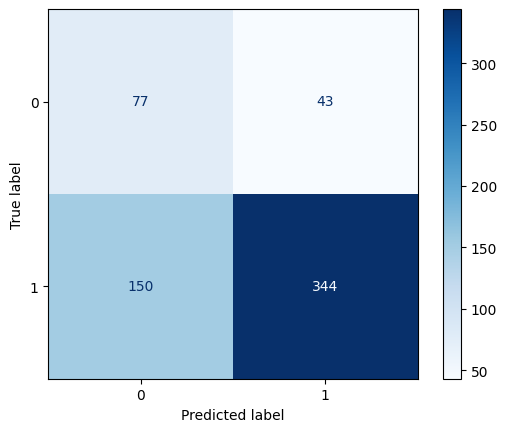

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from niapy.problems import Problem
# from niapy.task import OptimizationType, Task
# from niapy.algorithms.basic import ParticleSwarmAlgorithm

# # Fungsi untuk mendapatkan hyperparameter dari nilai partikel
# def get_hyperparameters(x):
#     C = 10 ** x[0]
#     kernel = 'rbf' if x[1] >= 0.5 else 'linear'
#     gamma = 10 ** x[2]
#     return {'C': C, 'kernel': kernel, 'gamma': gamma}

# def get_classifier(x):
#     params = get_hyperparameters(x)
#     return SVC(**params)

# # Definisi masalah optimasi untuk SVM
# class SVMHyperparameterOptimization(Problem):
#     def __init__(self, X_train, y_train, X_test, y_test):
#         super().__init__(dimension=3, lower=[-1, 0, -1], upper=[2, 1, 2])  # C, kernel (binary), gamma
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_test = X_test
#         self.y_test = y_test

#     def _evaluate(self, x):
#         model = get_classifier(x)
#         model.fit(self.X_train, self.y_train)
#         y_pred = model.predict(self.X_test)
#         accuracy = accuracy_score(self.y_test, y_pred)
#         return -accuracy  # Negasikan akurasi untuk tujuan minimisasi

# # Baca dataset ST-elevasi dan dataset kelas multiklas
# st_dataset = pd.read_csv('rs_features_full.csv')  # Fitur ST-elevasi
# class_dataset = pd.read_csv('ecg_mi_vs_normal_dataset.csv')  # Dataset kelas multiklas

# # Samakan format patient_id
# st_dataset['patient_id'] = st_dataset['patient_id'].str.replace('.hea', '', regex=False).str.strip().str.lower()
# class_dataset['patient_id'] = class_dataset['patient_id'].str.strip().str.lower()

# # Langkah 2: Gabungkan dataset berdasarkan 'patient_id'
# merged_dataset = st_dataset.merge(class_dataset, on='patient_id', how='inner')

# # Pisahkan fitur dan label
# X = merged_dataset[['Mean_RS', 'Max_RS', 'Min_RS', 'Std_RS']]
# y = merged_dataset['Class']  # Kolom Class dari ecg_multiclass_dataset.csv

# # Split data menjadi training dan testing set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Terapkan SMOTE untuk menyeimbangkan kelas pada data pelatihan
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Standarisasi fitur
# scaler = StandardScaler()
# X_train_resampled = scaler.fit_transform(X_train_resampled)
# X_test = scaler.transform(X_test)

# # Inisialisasi dan jalankan optimisasi
# problem = SVMHyperparameterOptimization(X_train_resampled, y_train_resampled, X_test, y_test)
# task = Task(problem, max_iters=50, optimization_type=OptimizationType.MINIMIZATION)
# algorithm = ParticleSwarmAlgorithm(population_size=20, seed=1234)

# best_params, best_accuracy = algorithm.run(task)

# # Tampilkan hasil optimasi
# print('Best parameters:', get_hyperparameters(best_params))
# print('Best accuracy:', -best_accuracy)

# # Evaluasi model terbaik
# best_model = get_classifier(best_params)
# best_model.fit(X_train_resampled, y_train_resampled)
# y_pred = best_model.predict(X_test)

# print(f"Akurasi Model Terbaik: {accuracy_score(y_test, y_pred) * 100:.2f}%")
# print(classification_report(y_test, y_pred, zero_division=0))
